In [1]:
import phoebe
from phoebe import u
import numpy as np
import matplotlib.pyplot as plt

In [2]:
b = phoebe.default_binary()

In [19]:
print(b.filter('logg', context='constraint'))

ParameterSet: 2 parameters
          logg@primary@constraint: log10((({mass@primary@component} / ({requiv@primary@component} ** 2.000000)) * 2942.206218) * 9.319541)
        logg@secondary@constraint: log10((({mass@secondary@component} / ({requiv@secondary@component} ** 2.000000)) * 2942.206218) * 9.319541)


In [20]:
print(b.filter('mass@primary', context='constraint'))

ParameterSet: 1 parameters
          mass@primary@constraint: (39.478418 * ({sma@binary@component} ** 3.000000)) / ((({period@binary@component} ** 2.000000) * (1.000000 + {q@binary@component})) * 2942.206217504419328179210424423218)


In [23]:
print(b.filter('mass@secondary', context='constraint'))

ParameterSet: 1 parameters
        mass@secondary@constraint: (39.478418 * ({sma@binary@component} ** 3.000000)) / ((({period@binary@component} ** 2.000000) * (1.000000 + (1.000000 / {q@binary@component}))) * 2942.206217504419328179210424423218)


In [41]:
b['mass@primary@component']

<Parameter: mass=0.9988131358058301 solMass | keys: description, value, quantity, default_unit, limits, visible_if, copy_for, readonly, advanced, latexfmt>

In [ ]:
log10((({mass@primary@component} / ({requiv@primary@component} ** 2.000000)) * 2942.206218) * 9.319541)

In [2]:
ref_rv = 2400000
btjd = 2457000

time, flux, flux_err = np.loadtxt('data/photometry/tess_corrected.txt', usecols=(0,1,2)).T
x_song, y_song, y_song_err = np.loadtxt('data/RV/SONG.txt', usecols=(0,1,2)).T

time += btjd
x_song += ref_rv

[Text(0, 0.5, 'Flux')]

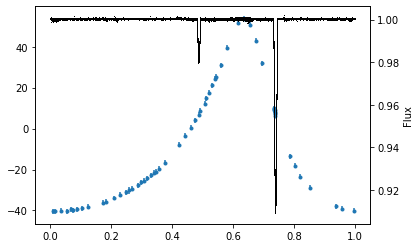

In [3]:
lit_period = 51.4213

plt.errorbar(x_song % lit_period / lit_period, y_song, yerr=y_song_err,fmt='.')
# plt.errorbar(x_bischoff % lit_period / lit_period, y_bischoff, yerr=y_bischoff_err, fmt='.')

ax2 = plt.twinx()
ax2.plot(time % lit_period / lit_period, flux, ',k')
ax2.set(ylabel='Flux')

In [4]:
# Our humble phoebe bundle
b = phoebe.default_binary()
b.add_dataset('lc',
             compute_phases=np.linspace(0,100,101),
              times=time, 
              fluxes=flux, 
              sigmas=flux_err,
              passband='TESS:T', 
              dataset='lc01',
             )

b.add_dataset('rv', 
              compute_phases=phoebe.linspace(0,1,201),
              times=x_song, 
              rvs={'primary': y_song}, 
              sigmas=y_song_err, 
              dataset='rv01')

b.set_value('pblum_mode', 'dataset-scaled')
b.set_value('period@orbit', lit_period)
b.set_value_all('ld_mode', 'lookup')

In [5]:
b.run_compute()

<ParameterSet: 8 parameters | kinds: rv, lc>

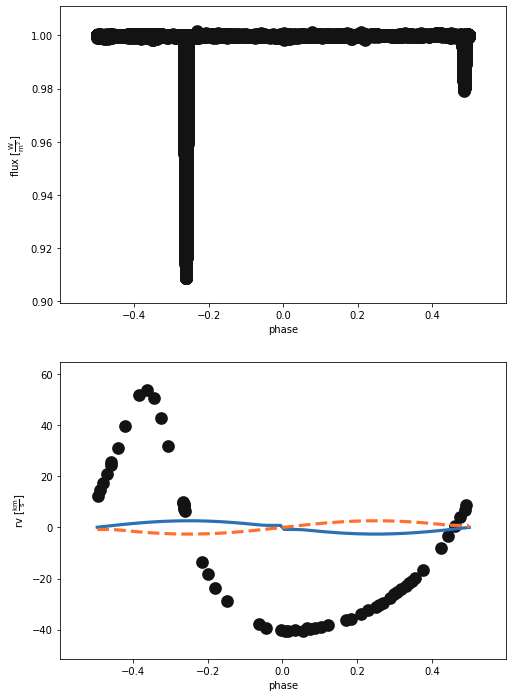

In [6]:
afig, mplfig = b.plot(x='phases', show=True)

In [7]:
b.add_solver('estimator.rv_geometry',
             rv='rv01')
b.run_solver(kind='rv_geometry', solution='rv_geom_sol')

<ParameterSet: 18 parameters | components: primary, secondary>

In [8]:
print(b.adopt_solution('rv_geom_sol'))
b.set_value('vgamma@system', -11.7708)

ParameterSet: 23 parameters
      t0_supconj@binary@component: -13.472049895939827 d
C         asini@primary@component: 43.007032402396945 solRad
             ecc@binary@component: 0.43726620835551766
            per0@binary@component: 7.759764866137705 deg
                    vgamma@system: 3.8674298391950686 km / s
C     t0_perpass@binary@component: -18.644151546320366 d
C         t0_ref@binary@component: -6.8972076494068295 d
C      compute_times@lc01@dataset: [ -13.4720499   37.9492501   89.3705501 ...
 5025.8153501 5077.2366501 5128.6579501] d
C      compute_times@rv01@dataset: [-13.4720499 -13.2149434 -12.9578369 ...
  37.4350371  37.6921436  37.9492501] d
             sma@binary@component: 86.01406480479389 solRad
C          ecosw@binary@component: 0.4332621181682777
C          esinw@binary@component: 0.05903959628883279
C    requiv_max@primary@component: 19.369386687588687 solRad
C  requiv_max@secondary@component: 19.369386687588687 solRad
C      mean_anom@binary@component: 130

In [9]:
b.run_compute()

<ParameterSet: 8 parameters | kinds: rv, lc>

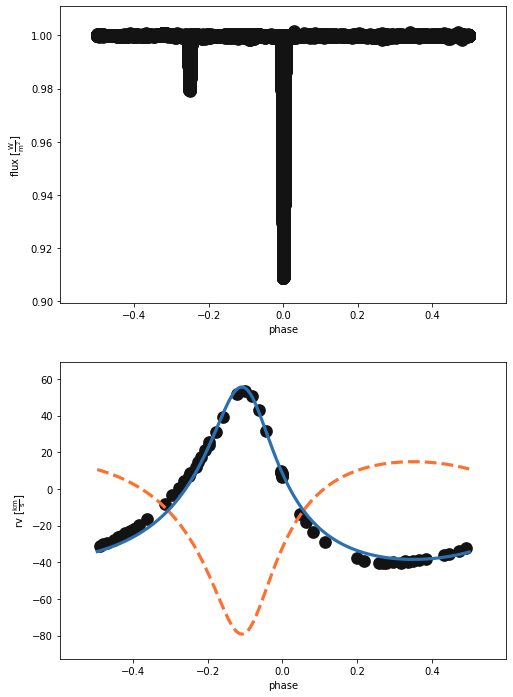

In [10]:
afig, mplfig = b.plot(x='phase',
                      show=True)

In [13]:
b.add_compute('ellc', compute='fastcompute')

ValueError: label 'fastcompute' is already in use.  Remove first or pass overwrite=True, if available.

In [15]:
b.flip_constraint('teffratio', solve_for='teff@primary')
b.flip_constraint('requivsumfrac', solve_for='requiv@primary')

ValueError: 0 results found for twig: 'teffratio', {'context': 'constraint', 'check_visible': True, 'check_default': True, 'check_advanced': False, 'check_single': False}

In [14]:
b.add_solver('optimizer.nelder_mead',
             fit_parameters=['teffratio', 'requivsumfrac', 'incl@binary', 'q', 'ecc', 'per0'],
             compute='fastcompute')

ValueError: ['teffratio', 'requivsumfrac'] are not valid selections.  Choices: ['t0@system', 'ra@system', 'dec@system', 'distance@system', 'vgamma@system', 'ebv@system', 'Av@system', 'Rv@system', 'requiv@primary@star@component', 'requiv_max@primary@star@component', 'requiv_min@primary@star@component', 'teff@primary@star@component', 'abun@primary@star@component', 'logg@primary@star@component', 'syncpar@primary@star@component', 'period@primary@star@component', 'freq@primary@star@component', 'pitch@primary@star@component', 'yaw@primary@star@component', 'incl@primary@star@component', 'long_an@primary@star@component', 'gravb_bol@primary@star@component', 'irrad_frac_refl_bol@primary@star@component', 'irrad_frac_lost_bol@primary@star@component', 'mass@primary@star@component', 'requiv@secondary@star@component', 'requiv_max@secondary@star@component', 'requiv_min@secondary@star@component', 'teff@secondary@star@component', 'abun@secondary@star@component', 'logg@secondary@star@component', 'syncpar@secondary@star@component', 'period@secondary@star@component', 'freq@secondary@star@component', 'pitch@secondary@star@component', 'yaw@secondary@star@component', 'incl@secondary@star@component', 'long_an@secondary@star@component', 'gravb_bol@secondary@star@component', 'irrad_frac_refl_bol@secondary@star@component', 'irrad_frac_lost_bol@secondary@star@component', 'mass@secondary@star@component', 'period@binary@orbit@component', 'period_anom@binary@orbit@component', 'freq@binary@orbit@component', 'dpdt@binary@orbit@component', 'per0@binary@orbit@component', 'dperdt@binary@orbit@component', 'ecc@binary@orbit@component', 't0_perpass@binary@orbit@component', 't0_supconj@binary@orbit@component', 't0_ref@binary@orbit@component', 'mean_anom@binary@orbit@component', 'incl@binary@orbit@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'long_an@binary@orbit@component', 'asini@binary@orbit@component', 'ecosw@binary@orbit@component', 'esinw@binary@orbit@component', 'sma@primary@star@component', 'asini@primary@star@component', 'sma@secondary@star@component', 'asini@secondary@star@component', 'sigmas_lnf@lc01@lc@dataset', 'pbflux@lc01@lc@dataset', 'l3@lc01@lc@dataset', 'l3_frac@lc01@lc@dataset', 'exptime@lc01@lc@dataset', 'pblum@primary@lc01@lc@dataset', 'pblum@secondary@lc01@lc@dataset', 'sigmas_lnf@primary@rv01@rv@dataset', 'sigmas_lnf@secondary@rv01@rv@dataset', 'rv_offset@primary@rv01@rv@dataset', 'rv_offset@secondary@rv01@rv@dataset']

In [ ]:
b.run_solver(kind='nelder_mead', maxiter=10000, solution='nm_sol')